In [15]:
import numpy as np
import pandas as pd
import librosa as lib
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,multilabel_confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import os


## Importar los rttm y convertirlos en un df

In [16]:
def read_rttm(file_path):
    columns = ['Type', 'File ID', 'Channel', 'Start Time', 'Duration', 'Ortho', 'Ortho1', 'SType', 'Conf']
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Start Time'] = df['Start Time'].astype(float)
    df['Duration'] = df['Duration'].astype(float)
    df['Conf'] = df['Conf'].astype(float)
    return df

def read_rttm_diar(file_path):
    columns = ['Type', 'File ID', 'Channel', 'Start Time', 'Duration', 'Ortho1', 'Ortho2', 'SType', 'Name1', 'Name2']
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    df['Start Time'] = df['Start Time'].astype(float)
    df['Duration'] = df['Duration'].astype(float)
    return df

file_path_rttm = 'raw_ROS-master/raw_ROS-master/alma-a1-nsb.rttm'
file_path_diar = 'raw_ROS-master/raw_ROS-master/alma-a1-nsb-diarization.rttm'

df_rttm = read_rttm(file_path_rttm)
df_rttm_diar = read_rttm_diar(file_path_diar)



In [17]:
print(df_rttm['SType'].unique().tolist())


['CHI', 'FA1', 'code', 'MA1', 'FC1', 'MC1', 'FA2', 'MC2', 'UC2', 'MA2', 'UC1']


In [18]:
conditions = [
    df_rttm["SType"] == "CHI",
    df_rttm["SType"].str.startswith("F"),
    df_rttm["SType"].str.startswith("M"),
    df_rttm["SType"].str.startswith("UC"),
    df_rttm["SType"].str.startswith("E")
]

choices = ["KCHI", "FEM", "MAL", "OCH","ELE"]

df_rttm["STypeNew"] = np.select(conditions, choices, default=df_rttm["SType"])
df_rttm


,Type,File ID,Channel,Start Time,Duration,Ortho,Ortho1,SType,Conf,STypeNew
0,SPEAKER,alma-a1-nsb,1,1925.01,0.19,NaN,NaN,CHI,1.0,KCHI
1,SPEAKER,alma-a1-nsb,1,1931.53,0.24,NaN,NaN,CHI,1.0,KCHI
2,SPEAKER,alma-a1-nsb,1,1964.12,0.31,NaN,NaN,CHI,1.0,KCHI
3,SPEAKER,alma-a1-nsb,1,1964.86,0.20,NaN,NaN,CHI,1.0,KCHI
4,SPEAKER,alma-a1-nsb,1,1971.15,0.49,NaN,NaN,CHI,1.0,KCHI
...,...,...,...,...,...,...,...,...,...,...
788,SPEAKER,alma-a1-nsb,1,3763.27,1.62,NaN,NaN,UC1,1.0,OCH
789,SPEAKER,alma-a1-nsb,1,3773.54,0.46,NaN,NaN,UC1,1.0,OCH
790,SPEAKER,alma-a1-nsb,1,8417.00,0.51,NaN,NaN,UC1,1.0,OCH
791,SPEAKER,alma-a1-nsb,1,8418.54,0.73,NaN,NaN,UC1,1.0,OCH


In [19]:
df_rttm_diar["STypeNew"]=df_rttm_diar["SType"]

In [20]:
# Modificar columnas
df_rttm_diar['Type'] = 'Diar'
df_rttm['Type'] = 'Elan'
df_rttm = df_rttm[['Type', 'File ID', 'Start Time', 'Duration', 'STypeNew']]



# Concatenar DataFrames
df_both = pd.concat([df_rttm, df_rttm_diar])

# Extraer el nombre entre 'casos/' y la siguiente '/'
name = "alma-a1-nsb"


print(name)

# Verificar el contenido del DataFrame concatenado
print("Contenido de df_both:")
print(df_both)


alma-a1-nsb
Contenido de df_both:
      Type                      File ID  Start Time  Duration STypeNew  \
0     Elan                  alma-a1-nsb    1925.010     0.190     KCHI   
1     Elan                  alma-a1-nsb    1931.530     0.240     KCHI   
2     Elan                  alma-a1-nsb    1964.120     0.310     KCHI   
3     Elan                  alma-a1-nsb    1964.860     0.200     KCHI   
4     Elan                  alma-a1-nsb    1971.150     0.490     KCHI   
...    ...                          ...         ...       ...      ...   
7036  Diar  alma-a1-nsb.mp3.diarization   14839.148     0.363     KCHI   
7037  Diar  alma-a1-nsb.mp3.diarization   14839.511     2.632      FEM   
7038  Diar  alma-a1-nsb.mp3.diarization   14842.367     0.111      FEM   
7039  Diar  alma-a1-nsb.mp3.diarization   14845.012     1.981      CHI   
7040  Diar  alma-a1-nsb.mp3.diarization   14845.116     1.559      FEM   

      Channel  Ortho1  Ortho2 SType  Name1  Name2  
0         NaN     NaN    

In [21]:
df_both["STypeNew"].unique()
# Eliminar filas con NaN en la columna 'STypeNew'
df_both = df_both.dropna(subset=['STypeNew'])


In [22]:
# --- Parámetros que ya tenías ---
step = 0.01

# --- Resultados que ya tenías ---
results = {
    'Elan_KCHI': [],
    'Elan_OCH': [],
    'Elan_FEM': [],
    'Elan_MAL': [],
    'Elan_ELE': [],
    'Diar_KCHI': [],
    'Diar_OCH': [],
    'Diar_FEM': [],
    'Diar_MAL': [],
    'Diar_SPEECH': []
}

# --- Asegurar tipos numéricos por las dudas ---
df_rttm["Start Time"] = pd.to_numeric(df_rttm["Start Time"], errors="coerce")
df_rttm["Duration"]  = pd.to_numeric(df_rttm["Duration"],  errors="coerce")

# --- Filtrar solo las filas "code" válidas ---
df_code = (
    df_rttm.loc[df_rttm["STypeNew"].eq("code"), ["Start Time", "Duration"]]
           .dropna()
           .query("`Duration` > 0")
           .sort_values("Start Time", kind="stable")
)

# --- Crear las ventanas [start, end) por cada fila con "code" ---
# end = start + duration
intervals = list(
    df_code.apply(lambda r: (float(r["Start Time"]), float(r["Start Time"] + r["Duration"])), axis=1)
)

# --- (Opcional) Unir/merging intervalos que se solapen o toquen, para evitar doble conteo ---
def merge_intervals(iv):
    if not iv:
        return iv
    iv_sorted = sorted(iv, key=lambda x: x[0])
    merged = [iv_sorted[0]]
    for s, e in iv_sorted[1:]:
        last_s, last_e = merged[-1]
        if s <= last_e:                 # solapado o contiguo
            merged[-1] = (last_s, max(last_e, e))
        else:
            merged.append((s, e))
    return merged

intervals = merge_intervals(intervals)

C:\Users\pablo\AppData\Local\Temp\ipykernel_25880\3335347668.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rttm["Start Time"] = pd.to_numeric(df_rttm["Start Time"], errors="coerce")
C:\Users\pablo\AppData\Local\Temp\ipykernel_25880\3335347668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rttm["Duration"]  = pd.to_numeric(df_rttm["Duration"],  errors="coerce")


In [23]:

# (Opcional) columna de fin para acelerar filtros
if "End Time" not in df_both.columns:
    df_both["End Time"] = df_both["Start Time"] + df_both["Duration"]

# --- Calcular total de pasos a procesar en todos los intervalos ---
total_steps = 0
for s, e in intervals:
    if e > s:
        # ceil para no perder el último escalón si (e - s) no es múltiplo exacto de step
        total_steps += int(np.ceil((e - s) / step))

# --- Barra de progreso global, iterando por intervalos y por i dentro de cada intervalo ---
with tqdm(total=total_steps, desc=f"Processing intervals ({len(intervals)} blocks)") as pbar:
    for s, e in intervals:
        # proteger de intervalos vacíos o invertidos
        if e <= s:
            continue

        for i in np.arange(s, e, step):
            # Verificar presencia de cada tipo en el instante i
            # (usa 'End Time' si la creaste; equivalente a Start+Duration)
            for key in results.keys():
                type_name, stype_new = key.split('_', 1)  # p.ej. 'Elan', 'KCHI'
                has_any = (df_both[
                    (df_both['Start Time'] <= i) &
                    (df_both['End Time'] > i) &  # si no creaste End Time, usa (df_both['Start Time'] + df_both['Duration'] > i)
                    (df_both['STypeNew'] == stype_new) &
                    (df_both['Type'] == type_name)
                ].shape[0] > 0)
                results[key].append(int(has_any))

            pbar.update(1)

# Crear DataFrame de resultados
df_results = pd.DataFrame(results)

# Verificación rápida
print("Contenido de df_results:")
print(df_results.head())

Processing intervals (15 blocks): 100%|██████████| 180000/180000 [53:55<00:00, 55.63it/s] 


Contenido de df_results:
   Elan_KCHI  Elan_OCH  Elan_FEM  Elan_MAL  Elan_ELE  Diar_KCHI  Diar_OCH  \
0          0         0         0         0         0          0         0   
1          0         0         0         0         0          0         0   
2          0         0         0         0         0          0         0   
3          0         0         0         0         0          0         0   
4          0         0         0         0         0          0         0   

   Diar_FEM  Diar_MAL  Diar_SPEECH  
0         0         0            0  
1         0         0            0  
2         0         0            0  
3         0         0            0  
4         0         0            0  


In [24]:
df_results.to_csv(f"resultados/{name}/df_results_{name}.csv")

In [25]:
df_resultados = pd.read_csv(f"resultados/{name}/df_results_{name}.csv")

# Lista de columnas que queremos verificar
cols_elan = ["Elan_KCHI", "Elan_OCH", "Elan_FEM", "Elan_MAL", "Elan_ELE"]
cols_diar = ["Diar_KCHI", "Diar_OCH", "Diar_FEM", "Diar_MAL", "Diar_SPEECH"]
# Crear la nueva columna Elan_NSpeech
df_resultados["Elan_SIL"] = (df_resultados[cols_elan].eq(0).all(axis=1)).astype(int)
df_resultados["Diar_SIL"] = 1 - df_resultados["Diar_SPEECH"]
df_resultados["Diar_ELE"] = 0

In [26]:
# Definir las etiquetas
labels = ['KCHI', 'OCH', 'FEM', 'MAL', 'ELE','SIL']

# Extraer las etiquetas verdaderas y predichas
y_true = df_resultados[['Elan_KCHI', 'Elan_OCH', 'Elan_FEM', 'Elan_MAL', 'Elan_ELE','Elan_SIL']].values
y_pred = df_resultados[['Diar_KCHI', 'Diar_OCH', 'Diar_FEM', 'Diar_MAL','Diar_ELE','Diar_SIL']].values

# Calcular la matriz de confusión multilabel
conf_matrix = multilabel_confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión para cada etiqueta
for i, label in enumerate(labels):
    print(f"Matriz de confusión para la etiqueta {label}:")
    print(conf_matrix[i])
    print()

# Opcionalmente, puedes imprimir un informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))


Matriz de confusión para la etiqueta KCHI:
[[150533  11307]
 [  4208  13952]]

Matriz de confusión para la etiqueta OCH:
[[177132      0]
 [  2868      0]]

Matriz de confusión para la etiqueta FEM:
[[131262  14453]
 [ 13247  21038]]

Matriz de confusión para la etiqueta MAL:
[[146176  12998]
 [ 11690   9136]]

Matriz de confusión para la etiqueta ELE:
[[180000      0]
 [     0      0]]

Matriz de confusión para la etiqueta SIL:
[[61315  9951]
 [31189 77545]]

Informe de clasificación:
              precision    recall  f1-score   support

        KCHI       0.55      0.77      0.64     18160
         OCH       0.00      0.00      0.00      2868
         FEM       0.59      0.61      0.60     34285
         MAL       0.41      0.44      0.43     20826
         ELE       0.00      0.00      0.00         0
         SIL       0.89      0.71      0.79    108734

   micro avg       0.71      0.66      0.68    184873
   macro avg       0.41      0.42      0.41    184873
weighted avg       0.

C:\Users\pablo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pablo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pablo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
df_resultados

,Unnamed: 0,Elan_KCHI,Elan_OCH,Elan_FEM,Elan_MAL,Elan_ELE,Diar_KCHI,Diar_OCH,Diar_FEM,Diar_MAL,Diar_SPEECH,Elan_SIL,Diar_SIL,Diar_ELE
0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
2,2,0,0,0,0,0,0,0,0,0,0,1,1,0
3,3,0,0,0,0,0,0,0,0,0,0,1,1,0
4,4,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,179995,0,0,0,1,0,1,0,0,0,1,0,0,0
179996,179996,0,0,0,1,0,1,0,0,0,1,0,0,0
179997,179997,0,0,0,1,0,1,0,0,0,1,0,0,0
179998,179998,0,0,0,1,0,1,0,0,0,1,0,0,0


In [28]:
# Cálculo de precisión, recall y F1-score
types = ['KCHI', 'OCH', 'FEM', 'MAL',"SIL"]

# Inicializar listas para almacenar las métricas
metrics = {
    'Tipo': [],
    'Precisión': [],
    'Recall': [],
    'F1-score': []
}

print("\nCalculando métricas de precisión, recall y F1-score:")
for t in tqdm(types, desc="Procesando tipos"):
    y_true = df_resultados['Elan_' + t]
    y_pred = df_resultados['Diar_' + t]
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Almacenar las métricas
    metrics['Tipo'].append(t)
    metrics['Precisión'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-score'].append(f1)
    
    # Imprimir los resultados
    print(f"\nResultados para el tipo {t}:")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Crear DataFrame de métricas
df_metrics = pd.DataFrame(metrics)


Calculando métricas de precisión, recall y F1-score:


Procesando tipos:  20%|██        | 1/5 [00:00<00:01,  3.56it/s]


Resultados para el tipo KCHI:
Precisión: 0.5524
Recall: 0.7683
F1-score: 0.6427

Resultados para el tipo OCH:
Precisión: 0.0000
Recall: 0.0000
F1-score: 0.0000


Procesando tipos:  80%|████████  | 4/5 [00:00<00:00,  5.34it/s]


Resultados para el tipo FEM:
Precisión: 0.5928
Recall: 0.6136
F1-score: 0.6030

Resultados para el tipo MAL:
Precisión: 0.4128
Recall: 0.4387
F1-score: 0.4253


Procesando tipos: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Resultados para el tipo SIL:
Precisión: 0.8863
Recall: 0.7132
F1-score: 0.7903


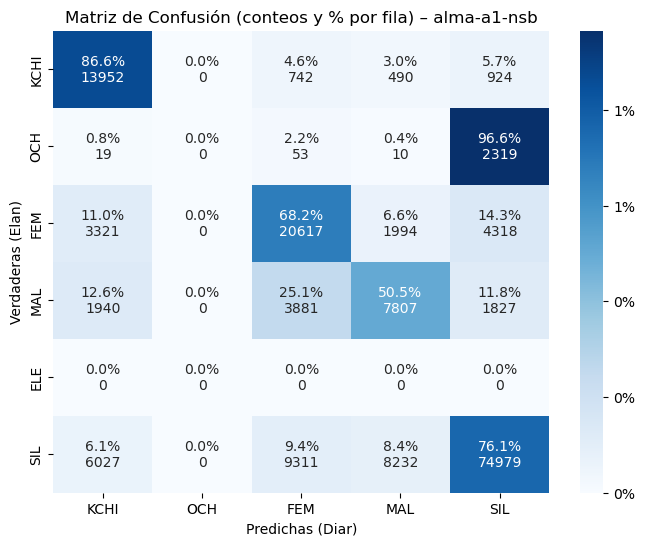


Calculando métricas de precisión, recall y F1-score:


Procesando tipos:  20%|██        | 1/5 [00:00<00:00,  4.49it/s]

KCHI | P=0.5524 R=0.7683 F1=0.6427


Procesando tipos:  40%|████      | 2/5 [00:00<00:00,  4.14it/s]

 OCH | P=0.0000 R=0.0000 F1=0.0000


Procesando tipos:  60%|██████    | 3/5 [00:00<00:00,  4.30it/s]

 FEM | P=0.5928 R=0.6136 F1=0.6030


Procesando tipos:  80%|████████  | 4/5 [00:00<00:00,  4.18it/s]

 MAL | P=0.4128 R=0.4387 F1=0.4253


Procesando tipos: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

 SIL | P=0.8863 R=0.7132 F1=0.7903

Tabla de métricas por clase:
    Tipo  Precisión    Recall  F1-score
0  KCHI   0.552358  0.768282  0.642668
1   OCH   0.000000  0.000000  0.000000
2   FEM   0.592770  0.613621  0.603015
3   MAL   0.412759  0.438682  0.425326
4   SIL   0.886269  0.713162  0.790348


In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    classification_report, precision_score, recall_score, f1_score,
    confusion_matrix
)

# --- 0) Asegurar columnas derivadas ---
if 'Elan_SIL' not in df_resultados.columns:
    cols_elan = ["Elan_KCHI","Elan_OCH","Elan_FEM","Elan_MAL","Elan_ELE"]
    df_resultados["Elan_SIL"] = (df_resultados[cols_elan].eq(0).all(axis=1)).astype(int)
if 'Diar_SIL' not in df_resultados.columns:
    df_resultados["Diar_SIL"] = 1 - df_resultados["Diar_SPEECH"]
if 'Diar_ELE' not in df_resultados.columns:
    df_resultados["Diar_ELE"] = 0  # ELE no está en diar, lo fijamos en 0

# --- 1) Etiquetas y prioridad para single-label ---
labels = ['KCHI','OCH','FEM','MAL','ELE','SIL']
priority = ['KCHI','FEM','MAL','OCH','ELE','SIL']  # ajustá a tu criterio

def multilabel_to_singlelabel_with_priority(Y, labels, priority):
    idx_of = {lab:i for i, lab in enumerate(labels)}
    prio_idx = [idx_of[lab] for lab in priority if lab in idx_of]
    out = []
    for row in Y:
        ones = np.where(row == 1)[0]
        if len(ones) == 0:
            out.append(-1)
        elif len(ones) == 1:
            out.append(ones[0])
        else:
            chosen = next((j for j in prio_idx if j in ones), ones[0])
            out.append(chosen)
    return np.array(out)

# --- 2) Matrices multilabel crudas (por si querés reporte multilabel) ---
Y_true = df_resultados[['Elan_KCHI','Elan_OCH','Elan_FEM','Elan_MAL','Elan_ELE','Elan_SIL']].values
Y_pred = df_resultados[['Diar_KCHI','Diar_OCH','Diar_FEM','Diar_MAL','Diar_ELE','Diar_SIL']].values

# --- 3) Single-label con prioridad para matriz de confusión compacta ---
y_true_sl = multilabel_to_singlelabel_with_priority(Y_true, labels, priority)
y_pred_sl = multilabel_to_singlelabel_with_priority(Y_pred, labels, priority)

valid = (y_true_sl != -1) & (y_pred_sl != -1)  # filtrá -1 en ambos
y_true_sl = y_true_sl[valid]
y_pred_sl = y_pred_sl[valid]

# --- 4) Matrices de confusión (conteos y normalizada por fila) ---
labels_idx = np.arange(len(labels))
cm_counts = confusion_matrix(y_true_sl, y_pred_sl, labels=labels_idx, normalize=None)
cm_norm   = confusion_matrix(y_true_sl, y_pred_sl, labels=labels_idx, normalize='true')

cm_counts_df = pd.DataFrame(cm_counts, index=labels, columns=labels)
cm_norm_df   = pd.DataFrame(cm_norm,   index=labels, columns=labels)

# Ocultar SOLO la columna 'ELE' en predichas
if 'ELE' in cm_counts_df.columns:
    cm_counts_df = cm_counts_df.drop(columns=['ELE'])
    cm_norm_df   = cm_norm_df.drop(columns=['ELE'])

annot = (cm_norm_df*100).round(1).astype(str) + "%" + "\n" + cm_counts_df.astype(int).astype(str)

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm_df, annot=annot, fmt='', cmap='Blues', cbar_kws={'format':'%.0f%%'})
plt.title(f'Matriz de Confusión (conteos y % por fila) – {name}')
plt.ylabel('Verdaderas (Elan)')
plt.xlabel('Predichas (Diar)')
os.makedirs(f'resultados/{name}', exist_ok=True)
plt.savefig(f'resultados/{name}/matriz_confusion_{name}.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 5) Métricas por etiqueta (binarias, una por clase) ---
types = ['KCHI','OCH','FEM','MAL','SIL']  # sin ELE si no querés reportarla
metrics = {'Tipo':[], 'Precisión':[], 'Recall':[], 'F1-score':[]}

print("\nCalculando métricas de precisión, recall y F1-score:")
for t in tqdm(types, desc="Procesando tipos"):
    yt = df_resultados['Elan_' + t]
    yp = df_resultados['Diar_' + t]
    p  = precision_score(yt, yp, zero_division=0)
    r  = recall_score(yt, yp, zero_division=0)
    f1 = f1_score(yt, yp, zero_division=0)
    metrics['Tipo'].append(t); metrics['Precisión'].append(p)
    metrics['Recall'].append(r); metrics['F1-score'].append(f1)
    print(f"{t:>4s} | P={p:.4f} R={r:.4f} F1={f1:.4f}")

df_metrics = pd.DataFrame(metrics)
print("\nTabla de métricas por clase:\n", df_metrics)

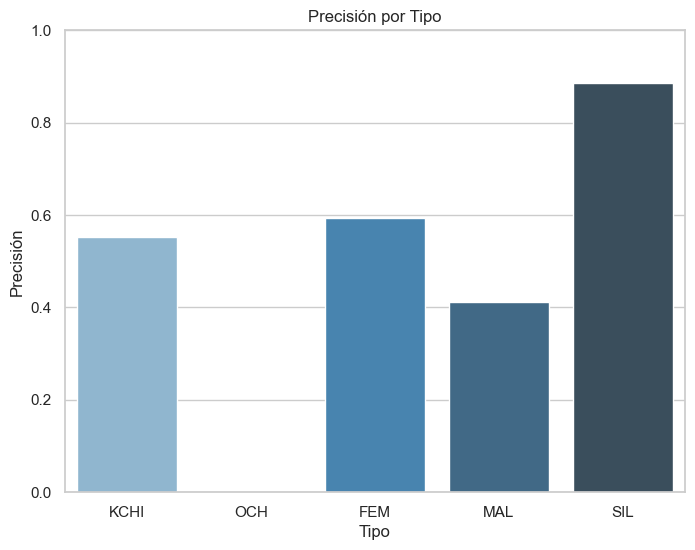

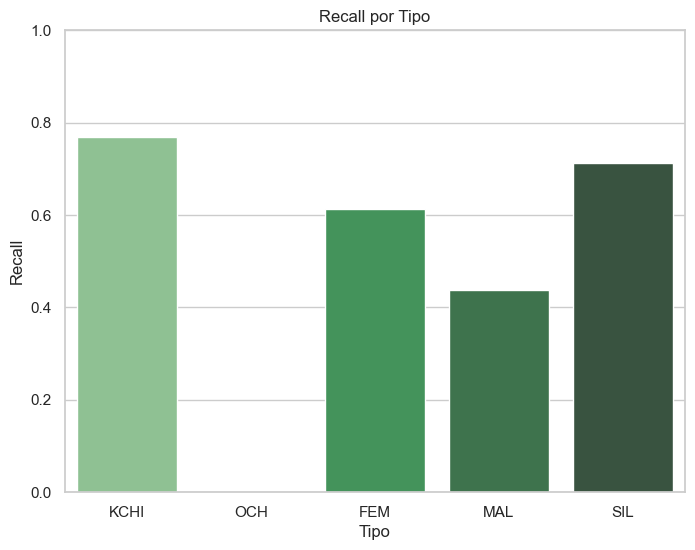

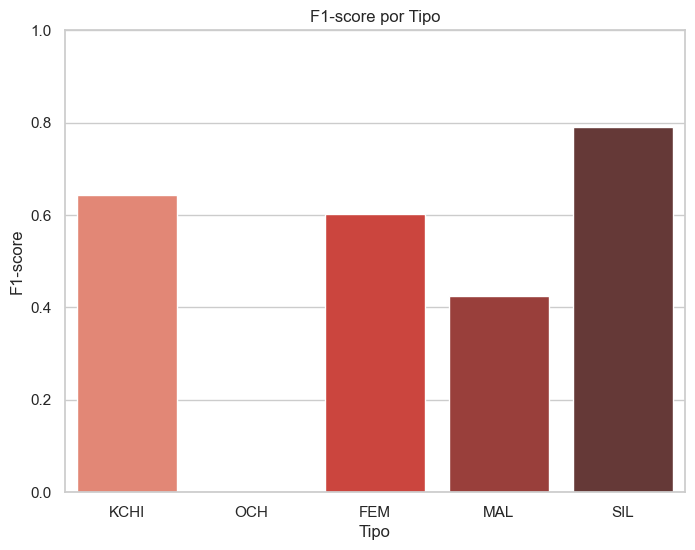

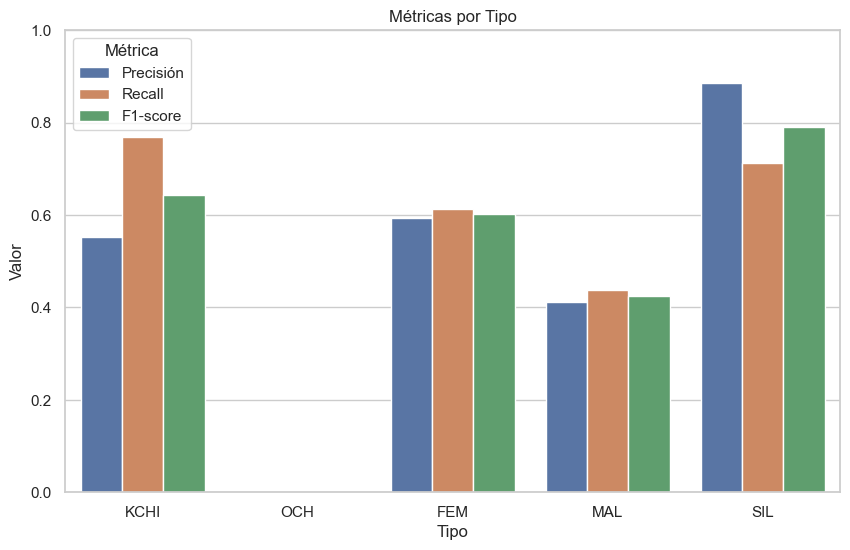

In [30]:
# Generar gráficos
sns.set(style="whitegrid")

# Gráfico de barras para Precisión
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Precisión', data=df_metrics, palette='Blues_d')
plt.title('Precisión por Tipo')
plt.ylim(0, 1)
plt.ylabel('Precisión')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/precision_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

# Gráfico de barras para Recall
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='Recall', data=df_metrics, palette='Greens_d')
plt.title('Recall por Tipo')
plt.ylim(0, 1)
plt.ylabel('Recall')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/recall_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

# Gráfico de barras para F1-score
plt.figure(figsize=(8, 6))
sns.barplot(x='Tipo', y='F1-score', data=df_metrics, palette='Reds_d')
plt.title('F1-score por Tipo')
plt.ylim(0, 1)
plt.ylabel('F1-score')
# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/f1score_{name}.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico combinado
df_metrics_melted = pd.melt(df_metrics, id_vars=['Tipo'], value_vars=['Precisión', 'Recall', 'F1-score'], var_name='Métrica', value_name='Valor')

plt.figure(figsize=(10, 6))
sns.barplot(x='Tipo', y='Valor', hue='Métrica', data=df_metrics_melted)
plt.title('Métricas por Tipo')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.legend(title='Métrica')

# Guardar la figura como un archivo PNG
plt.savefig(f'resultados/{name}/combinado_{name}.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
# Seleccionar las columnas que empiezan con "Diar_"
diar_columns = [col for col in df_resultados.columns if col.startswith('Diar_')]

# Cambiar los valores de 1 a 0.8 en esas columnas
df_resultados[diar_columns] = df_resultados[diar_columns].replace(1, 0.8)

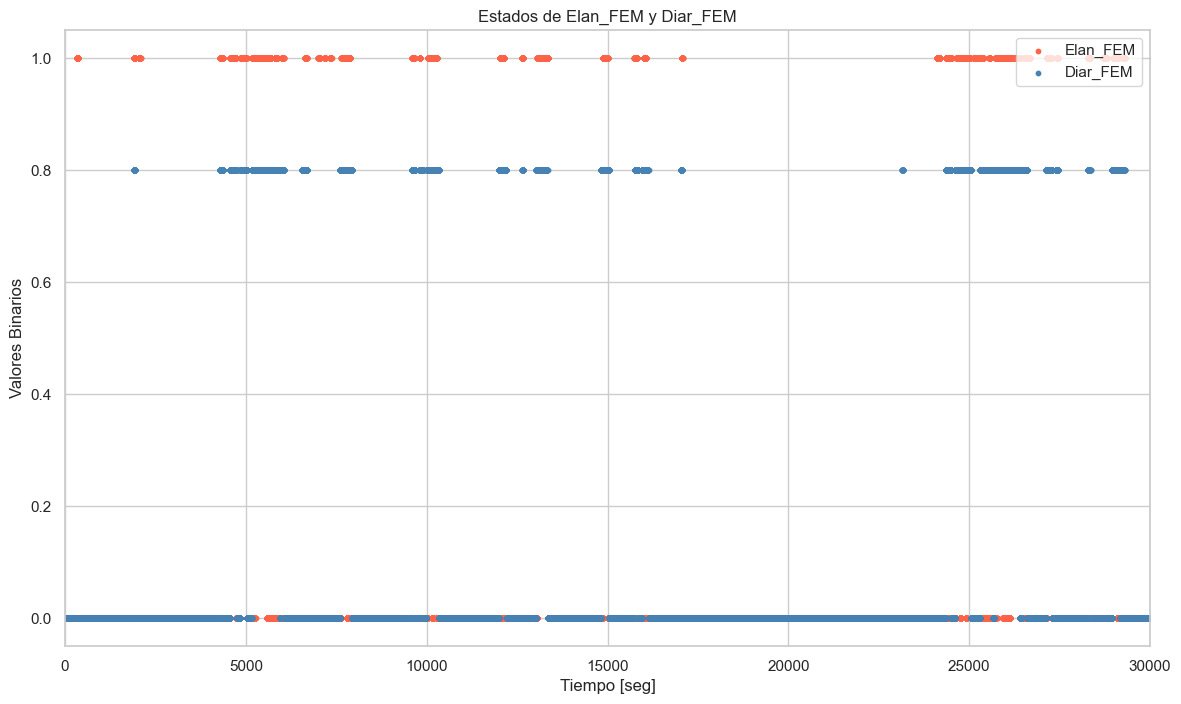

In [32]:
# Definir las columnas que deseas graficar
columns_to_plot = ['Elan_FEM', 'Diar_FEM']

# Definir colores contrastantes
colors = ['#FF6347', '#4682B4']  # Tomato y SteelBlue

# Crear la gráfica de dispersión para mostrar solo los estados sin transiciones
plt.figure(figsize=(14, 8))

# Graficar solo los puntos donde el valor es 1
for i, column in enumerate(columns_to_plot):
    plt.scatter(df_resultados.index, df_resultados[column], label=column, color=colors[i], s=10)

# Configuración del gráfico
plt.title('Estados de Elan_FEM y Diar_FEM')
plt.xlabel('Tiempo [seg]')
plt.ylabel('Valores Binarios')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(0, 30000)

# Guardar la figura como un archivo PNG
# plt.savefig(f'binarios_{name}.png', dpi=300, bbox_inches='tight')
# Mostrar la gráfica
plt.show()
